# This notebook 
## 1. Calculates the alignment between coastal normal vectors and ERA 5 wind velocity vectors
## 2. Explores the correlation between normal/velocity vector alignment and probability of beaching

In [7]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [8]:
# dependencies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from tqdm import tqdm

import scipy.interpolate as sci_int
import scipy.stats as sci_stats
import geopandas as gpd

In [9]:
# load u and v CSVs:
u_df = pd.read_csv('u_df.csv')
v_df = pd.read_csv('v_df.csv')

# load wind CSV:
avg_u_winds = pd.read_csv('avg_u_winds.csv')
avg_v_winds = pd.read_csv('avg_v_winds.csv')

# load probability of beaching data
beach_undrogued = pd.read_csv('undrogued_beach.csv')
unbeach_undrogued = pd.read_csv('undrogued_unbeach.csv')

### First we need to reduce the dimensions of the wind data by averaging:

In [10]:
def df_aggregation_by_factor_8(df):
    # keep original df unaffected
    working_df = df.copy()

    # initialize row mean:
    row_means = []
    
    # for each odd row    
    for i in tqdm(range(0, len(working_df), 2)):

        # initialize column mean:
        col_means = []
        
        # for each odd col
        for j in range(0, len(working_df.columns), 2):  

            # get 3x3 matrix around current grid cell
            matrix = working_df.iloc[i-1:i+2, j-1:j+2].values
            
            # get mean of matrix
            matrix_mean = matrix.mean()
            
            col_means.append(matrix_mean)
            
        row_means.append(col_means)
        
    result_df = pd.DataFrame(row_means)
    
    return result_df

In [12]:
# define desired rows and desired cols
desired_rows = 180
desired_cols = 90

# perform aggregation on wind dfs:
u_winds = df_aggregation_by_factor_8(df_aggregation_by_factor_8(df_aggregation_by_factor_8(avg_u_winds.iloc[:-1,:])))
v_winds = df_aggregation_by_factor_8(df_aggregation_by_factor_8(df_aggregation_by_factor_8(avg_v_winds.iloc[:-1,:])))

# define lat and lon:
lats = np.linspace(-90,90,90)[10:-10]
lons = np.linspace(-180, 180, 180)

# flip vertically
u_winds = u_winds.iloc[::-1]
v_winds = v_winds.iloc[::-1]

# shift 180 degrees lon
u_winds =  pd.concat([u_winds.iloc[:, u_winds.shape[1] // 2:], u_winds.iloc[:, :u_winds.shape[1] // 2]], axis=1)
v_winds =  pd.concat([v_winds.iloc[:, v_winds.shape[1] // 2:], v_winds.iloc[:, :v_winds.shape[1] // 2]], axis=1)

100%|██████████| 90/90 [00:01<00:00, 55.68it/s]


In [13]:
# remove beyond -70 and 70 degrees lat:
u_winds1 = u_winds[10:-10]
v_winds1 = v_winds[10:-10]

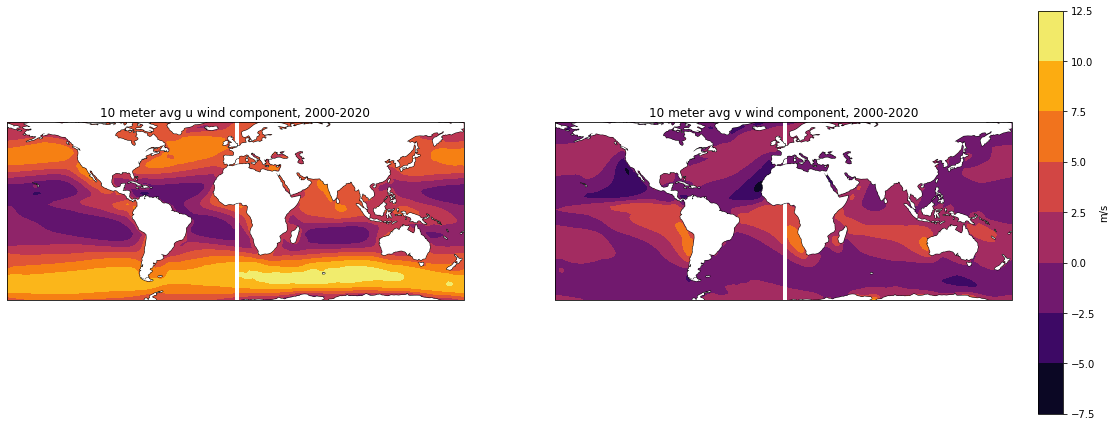

In [15]:
# visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8),
                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

# Plot the u-component of wind
ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
im1 = ax1.contourf(lons, lats, u_winds1, cmap='inferno', transform=ccrs.PlateCarree())
ax1.set_title('10 meter avg u wind component, 2000-2020')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax1.add_feature(land_feature)

# Plot the v-component of wind
ax2.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
im2 = ax2.contourf(lons, lats, v_winds1, cmap='inferno', transform=ccrs.PlateCarree())
ax2.set_title('10 meter avg v wind component, 2000-2020')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

ax2.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax2.add_feature(land_feature)

# Create a single colorbar for both plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im2, cax=cbar_ax, label='m/s')

# Adjust layout
plt.subplots_adjust(wspace=0.2, right=0.9)  # wspace for width space, right to make space for colorbar

# Show the plot
plt.show()

### Now we calculate the alignment of the coastal normal vectors and wind vectors:

In [16]:
u_df_array = u_df.values
v_df_array = v_df.values
u_winds_array = u_winds1.values
v_winds_array = v_winds1.values

# compute dot product of coastal normal vectors and wind velocity vectors
dot_product = u_df_array * u_winds_array + v_df_array * v_winds_array

# put into 'alignment' dataframe
alignment = pd.DataFrame(dot_product)

### Let's compare these alignments to the probability of beaching in those grid cells

In [58]:
# we follow the steps in the probability of beaching notebook:
# get beached lats and lons
beach_undrogued_lats = np.array(beach_undrogued['lat'])
beach_undrogued_longs = np.array(beach_undrogued['lon'])

# get unbeached lats and lons
unbeach_undrogued_lats = np.array(unbeach_undrogued['lat'])
unbeach_undrogued_longs = np.array(unbeach_undrogued['lon'])


In [59]:
# let's use sci_stats.binned_statistic_2d to bin by lat/lon and count

# beached
n_lons, n_lats = 180, 90 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

beach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    beach_undrogued_longs,beach_undrogued_lats,values=beach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

# unbeached
n_lons, n_lats = 180, 90 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

unbeach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    unbeach_undrogued_longs,unbeach_undrogued_lats,values=unbeach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

In [60]:
def probability_of_beaching(beached_count, unbeached_count):
    probability = beached_count / (beached_count + unbeached_count)
    return probability

In [61]:
probability_undrogued = probability_of_beaching(beach_undrogued_stat, unbeach_undrogued_stat).T

# put into 'beach_prob' dataframe and remove data past -70 and 70 degrees lat:
beach_prob = pd.DataFrame(probability_undrogued).iloc[10:-10]
beach_prob_vals = beach_prob.values

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


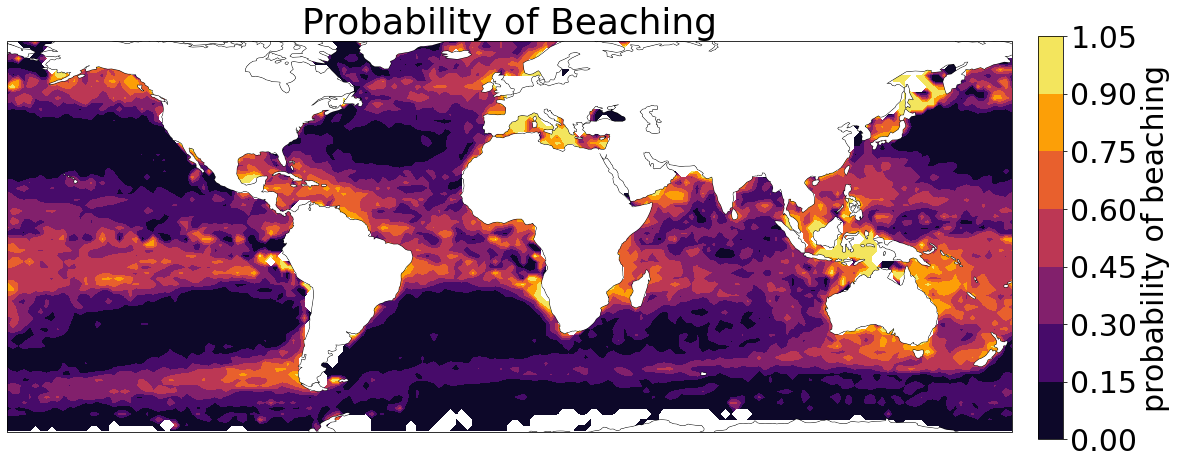

In [66]:
# visualize
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 8),
                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

# Plot the u-component of wind
ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())
im1 = ax1.contourf(lons, lats, beach_prob_vals, cmap='inferno', transform=ccrs.PlateCarree())
ax1.set_title('Probability of Beaching')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax1.add_feature(land_feature)

# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im1, cax=cbar_ax, label='probability of beaching')

# Show the plot
plt.show()

#### So at every location that is coastal (has a non_NAN 'alignment' value), we want to see what the probability of beaching is

In [69]:
# initialize output lists
beach_prob_list = []
alignment_list = []

# through rows
for i in range(alignment.shape[0]):
    
    # through cols
    for j in range(alignment.shape[1]):
        
        # if not NAN
        if not np.isnan(alignment.iloc[i, j]):
            
            # append value from beach_prob and alignment to their list
            beach_prob_list.append(beach_prob.iloc[i, j])
            alignment_list.append(alignment.iloc[i, j])

In [104]:
# id nan indices
nan_indices = np.isnan(np.array(alignment_list)) | np.isnan(np.array(beach_prob_list))

# remove nans
alignment_list_f = np.array(alignment_list)[~nan_indices]
beach_prob_list_f = np.array(beach_prob_list)[~nan_indices]

# fit a line:
coefficients  = np.polyfit(alignment_list_f, beach_prob_list_f, 1)
predicted_values = np.polyval(coefficients, alignment_list_f)

# calculate r2
p = np.poly1d(coefficients)
r_squared = np.corrcoef(beach_prob_list_f, p(alignment_list_f))[0, 1] ** 2

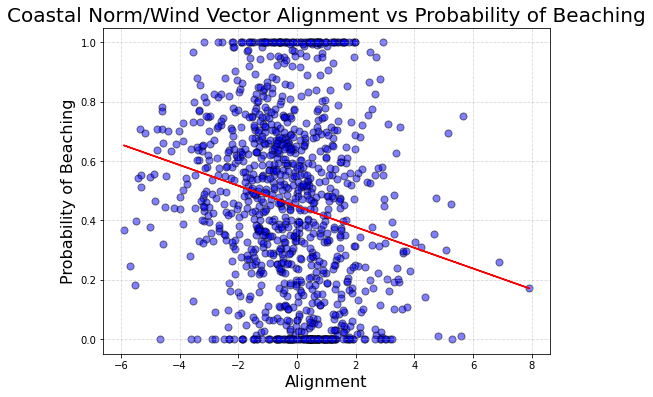

In [112]:
# visualize correlation between the two
plt.figure(figsize=(8, 6))
plt.scatter(alignment_list, beach_prob_list, s=50, c='blue', alpha=0.5, edgecolors='k')
plt.plot(alignment_list_f, predicted_values, color='r', linestyle='-', label='Fitted Line')

plt.grid(True, linestyle='--', alpha=0.5)

plt.xlabel('Alignment', fontsize=16)
plt.ylabel('Probability of Beaching', fontsize=16)

plt.tick_params(axis='both', which='both', labelsize=10)

plt.title('Coastal Norm/Wind Vector Alignment vs Probability of Beaching', fontsize=20)

plt.show()